In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("muted")


In [6]:
path = '/home/nguu0123/git/thesis/ray_deployment/logs/'
original = pd.read_csv(path + 'response_time_original.csv', names=["image_id", "response_time"], skiprows=50)
async_with_class = pd.read_csv(path + 'response_time_prov_async_with_class.csv', names=["image_id", "requestId","response_time", "correctly_detect", "true_class"], skiprows=50)
prov = pd.read_csv(path + 'response_time_with_prov.csv', names=["image_id", "requestId","response_time", "correctly_detect", "true_class"], skiprows=50)

In [7]:
def get_average(data, windows):
    return data.rolling(windows).mean().tolist()[windows - 1:]
def get_p99(data, windows):
    return data.rolling(windows).quantile(0.99).tolist()[windows - 1:]

In [8]:
print('mean ',original['response_time'].mean())
print('min', original['response_time'].min())
print('max', original['response_time'].max())
print('p99', original['response_time'].quantile(0.99))

mean  0.39472195227188767
min 0.2139430046081543
max 0.5672919750213623
p99 0.5505049228668213


In [9]:
print('mean ',prov['response_time'].mean())
print('min', prov['response_time'].min())
print('max', prov['response_time'].max())
print('p99', prov['response_time'].quantile(0.99))

mean  0.30578764045939727
min 0.1697614192962646
max 0.4478776454925537
p99 0.4272766923904419


In [10]:
original_RT = get_average(original['response_time'], 30)
async_prov = get_average(async_with_class['response_time'], 30)
sns_plot = sns.lineplot(y=original_rt, x=range(len(original_rt)), label='without lineage' )
sns_plot = sns.lineplot(y=async_prov, x=range(len(async_prov)),  label='with lineage')
sns_plot.set_xlabel("Request Number")
sns_plot.set_ylabel("Average Response Time (s)")
#sns_plot.figure.savefig("mean.pdf", bbox_inches='tight')

NameError: name 'original_rt' is not defined

Text(0, 0.5, 'P99 Response Time (s)')

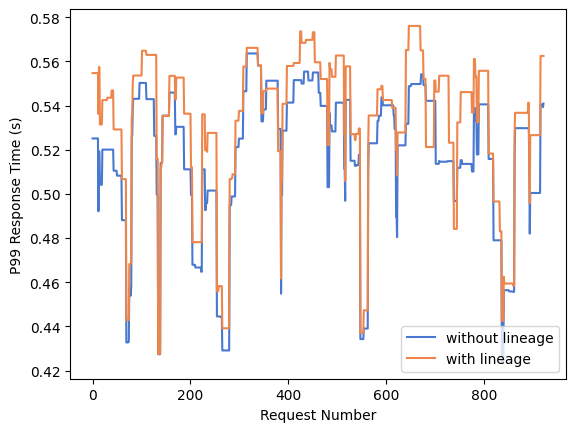

In [ ]:
original_RT = get_p99(original['response_time'], 30)
async_prov = get_p99(async_with_class['response_time'], 30)
sns_plot = sns.lineplot(y=original_RT, x=range(len(original_RT)), label='without lineage' )
sns_plot = sns.lineplot(y=async_prov, x=range(len(async_prov)),  label='with lineage')
sns_plot.set_xlabel("Request Number")
sns_plot.set_ylabel("P99 Response Time (s)")
#sns_plot.figure.savefig("p99.pdf", bbox_inches='tight')

In [ ]:
import psycopg
import json
import datetime
config = (
        "user=nguu0123 password=nguu0123456 host=172.17.0.2 port=5432 dbname=nguu0123"
    )
connection = psycopg.connect(config, autocommit=True)
cursor = connection.cursor()
cursor.execute("""select predict.start_time,predict.end_time, model.id as modelId, model.name from predict
inner join wasassociatedwith on predict.id = wasassociatedwith.activityid
inner join model on wasassociatedwith.agentid = model.id
               """)
data = cursor.fetchall()
data = list(map(lambda x: [x[0].timestamp(), x[1].timestamp(), str(x[2]), x[3]], data))
data = pd.DataFrame(data, columns=['start_time', 'end_time', 'id', 'model_name'])
data['respond_time'] = data['end_time'] - data['start_time']

OperationalError: connection failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?

In [ ]:
data[data['model_name'] == 'Yolo5Inference']['id'].unique()

array(['e3f3be37-84cd-4e50-80e9-d6e120f7d06f',
       'fa4c032d-6add-40b2-9bdf-5cd8c120d4f1',
       '4ad0835f-a3ca-4a89-9abe-177334ec9198'], dtype=object)

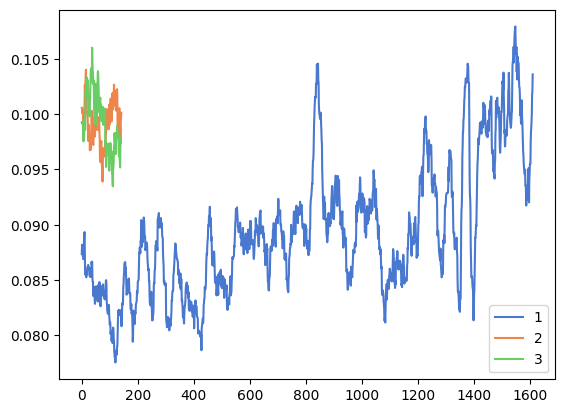

In [ ]:
i = 1
for x in data[data['model_name'] == 'Yolo5Inference']['id'].unique():
    respond_time = data[data['id'] == x]['respond_time']
    respond_time_average = get_average(respond_time, 30)
    sns_plot = sns.lineplot(y=respond_time_average, x=range(len(respond_time_average)), label='{}'.format(i) )
    i += 1

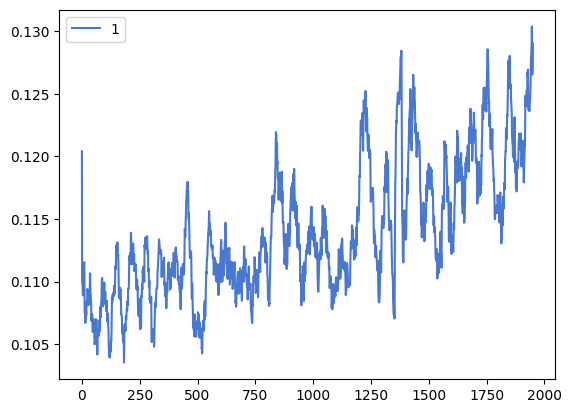

In [ ]:
for x in data[data['model_name'] == 'Yolo8Inference']['id'].unique():
    respond_time = data[data['id'] == x]['respond_time']
    respond_time_average = get_average(respond_time, 30)
    sns_plot = sns.lineplot(y=respond_time_average, x=range(len(respond_time_average)), label='1' )

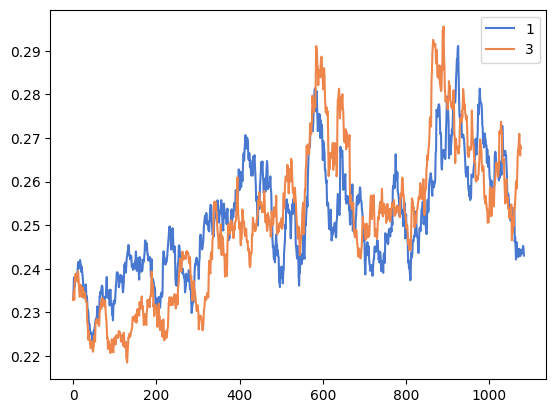

In [ ]:
respond_time = data[data['id'] == 'f8e8b1bb-8a85-47a8-ad44-b8fc5f758c76']['respond_time']
respond_time_1 = data[data['id'] == '0fe06f9a-f3ed-4c38-994c-32c44d3b4155']['respond_time']
respond_time_2 = data[data['id'] == 'ef299c38-8ce4-4289-9cbb-ad5bd569bd8b']['respond_time']
respond_time_3 = data[data['id'] == '22df1a30-0534-4bdd-a998-b0f97fda5968']['respond_time']
respond_time_average = get_average(respond_time, 30)
respond_time_1_average = get_average(respond_time_1, 30)
respond_time_2_average = get_average(respond_time_2, 30)
respond_time_3_average = get_average(respond_time_3, 30)
sns_plot = sns.lineplot(y=respond_time_average, x=range(len(respond_time_average)), label='1' )
sns_plot = sns.lineplot(y=respond_time_2_average, x=range(len(respond_time_2_average)), label='3' )

In [31]:
import psycopg
import json
config = (
        "user=nguu0123 password=nguu0123456 host=172.17.0.3 port=5432 dbname=nguu0123"
    )
prov = pd.read_csv(path + 'response_time_with_prov.csv', names=["image_id", "requestId","response_time", "correctly_detect", "true_class"], skiprows=50)
connection = psycopg.connect(config, autocommit=True)
cursor = connection.cursor()
cursor.execute(""" 
select assessdataquality.requestid, dataqualityreport.value from dataqualityreport
inner join wasgeneratedby on wasgeneratedby.entityid = dataqualityreport.id
inner join assessdataquality on wasgeneratedby.activityid = assessdataquality.id
""")
data = cursor.fetchall()
requestId = list(map(lambda x: x[0], data))
data = list(map(lambda x: x[1], data))
data = pd.DataFrame(data)
data['request id'] = requestId

In [32]:
data

,resolution,contrast,sharpness,brightness,saturation,noise,blur,request id
0,"[640, 425]",2116.09,2116.09,147.77,37.96,28.728676,2116.085033,03b5d7bc-9118-4819-af6c-caa3f7615e56
1,"[640, 400]",1779.25,1779.25,145.02,7.63,1.362109,1779.246757,78c3b7f6-56e5-48bf-a6d2-c7f0c9ecd1d0
2,"[640, 480]",577.82,577.82,126.50,63.13,1.389323,577.822812,cf6307c1-7054-4dfd-8faf-3c9342fe5e57
3,"[427, 640]",10297.22,10297.22,103.00,87.03,19.771663,10297.224026,07038f27-4a21-4998-b888-cfa9ae452c92
4,"[640, 450]",2276.93,2276.93,91.13,54.38,37.082986,2276.932627,8041d2b8-9316-485e-a4d2-802a92b76ecd
...,...,...,...,...,...,...,...,...
1087,"[640, 427]",1057.43,1057.43,126.47,32.72,1.786812,1057.427928,a318fe94-0183-4df4-8176-62a5348e8009
1088,"[640, 480]",1714.40,1714.40,109.12,127.99,8.325846,1714.396327,7e556cf1-cb6f-4b07-ab04-0cc664a4304c
1089,"[640, 427]",662.93,662.93,78.59,126.94,48.590823,662.926672,e860e9a8-1b0c-4b91-9152-e0faa1a048d9
1090,"[640, 480]",1505.17,1505.17,114.39,53.33,10.687826,1505.165879,97de201f-7f91-4ac2-b6bd-db4463d98bac


In [8]:
import psycopg
import json
config = (
        "user=nguu0123 password=nguu0123456 host=172.17.0.3 port=5432 dbname=nguu0123"
    )
connection = psycopg.connect(config, autocommit=True)
cursor = connection.cursor()
cursor.execute("select value,requestid from predictionquality")
data = cursor.fetchall()
data = list(map(lambda x: [x[1], x[0]['mem'][1],x[0]['cpu']['after']['user'] +  x[0]['cpu']['after']['system'] - x[0]['cpu']['before']['user'] - x[0]['cpu']['before']['system'] ], data))
data = pd.DataFrame(data, columns=['requestId','peak_memory_usage', 'cpu usage'])
data['peak_memory_usage'] = data['peak_memory_usage'] / (1024*1024)
data = data.groupby('requestId').sum().reset_index()

In [71]:
data

,requestId,peak_memory_usage,cpu usage
0,00031f58-ae18-4c5a-bfd5-b3d8c7e43fee,5.868468,0.42
1,005b1b73-90c3-4093-ac03-db95c5b8c863,4.989562,0.35
2,00dd509e-ebbb-4d83-8bcd-7f4a43672b5a,4.110656,0.28
3,00efaeae-79e7-4299-8faf-35584904e671,2.645812,0.20
4,0131c959-f6d8-4c54-b5a4-677ca42f4cee,4.403625,0.32
...,...,...,...
995,fe5446d9-e9f8-4d63-996c-a3625868e3ef,4.403625,0.32
996,fe592dab-0a1b-4d86-ab0c-2b0030ec699b,4.110656,0.28
997,fe7a7d56-b249-424e-a784-2f634755236f,4.403625,0.31
998,feba9a6b-1223-4252-a300-66346706688c,4.696593,0.34


In [72]:
async_with_class

,image_id,requestId,response_time,correctly_detect,true_class
0,17554656478_22dea58ed2_z.jpg,c336f1ad-0e59-44f9-b81b-d60d7b697a9d,0.378106,1,car
1,506974894_b74672813b_z.jpg,9c68f047-3974-4faa-94c3-f2b4e96fc0af,0.370350,1,dog
2,15983066535_629c335c63_z.jpg,e7792529-2835-4aac-afef-5776ad64df60,0.368726,1,person
3,15038212434_9e0e575008_z.jpg,b5274bca-e607-4e4d-8417-1970f7585dc3,0.553061,0,car
4,144429519_9567ff4044_z.jpg,c808f098-4663-43e5-9954-2c22315c5b57,0.376416,1,car
...,...,...,...,...,...
696,18285977255_534ec8e749_z.jpg,3a11b88e-6fdd-4076-bbe9-e2e4d1d5655a,0.380049,0,cat
697,4901520304_aa5c10705e_z.jpg,bb84d765-4598-4202-9f45-42798d33f356,0.413351,1,person
698,2718097307_1fb900f17a_z.jpg,f0db4a63-3a68-4355-a292-2b9ca2d857fc,0.379152,1,cat
699,3715997008_28a251eba7_z.jpg,a439c916-4413-4477-ad69-d965864a17b2,0.375859,0,bicycle


In [73]:
resourceUsedData = pd.merge(data, async_with_class, on='requestId', how='inner')

In [74]:
resourceUsedData.describe()

,peak_memory_usage,cpu usage,response_time,correctly_detect
count,701.000000,701.000000,701.000000,701.000000
mean,4.367747,0.314822,0.403061,0.817404
std,0.528767,0.038676,0.052624,0.386611
min,2.645812,0.190000,0.225839,0.000000
25%,4.110656,0.290000,0.371072,1.000000
50%,4.403625,0.310000,0.396270,1.000000
75%,4.403625,0.320000,0.421655,1.000000
max,5.894240,0.450000,0.580235,1.000000


In [112]:
resourceUsedData[resourceUsedData['correctly_detect'] == 0]

,requestId,peak_memory_usage,cpu usage,image_id,response_time,correctly_detect,true_class,price
11,03619751-969c-4a53-befd-c61d8c8b930e,4.403625,0.33,2468082692_49ec682990_z.jpg,0.403987,0,car,0.003852
12,03a51e40-985c-4e4a-8b2e-475cbebef9e2,4.403625,0.30,3595778703_d3bec2f74e_z.jpg,0.417057,0,car,0.003702
14,05885731-89a1-427d-8b6a-a0746ad16d43,4.403625,0.32,14351072751_334621d203_z.jpg,0.419320,0,dog,0.003802
20,092500a5-dea5-40ae-ba2c-98952e1d84e6,4.110656,0.31,211850545_7f670901ab_z.jpg,0.378453,0,car,0.003605
26,0cb06d75-da57-468c-b0d1-b9dad3afdbd6,4.133390,0.28,5827517048_a890acd7e6_z.jpg,0.383892,0,dog,0.003467
...,...,...,...,...,...,...,...,...
670,f479e8f2-5bdb-40fd-838f-810f34397891,3.524718,0.25,9031823026_3e55960d76_z.jpg,0.321918,0,dog,0.003012
671,f4e60ade-9812-4cb9-86a2-e08e9f3af5f4,4.403625,0.32,4941417139_1608ab2596_z.jpg,0.410714,0,dog,0.003802
680,f731dd29-0cf6-47b0-bb1c-86b8c7d6419d,4.110656,0.29,2179537346_d695661bbc_z.jpg,0.492232,0,bicycle,0.003505
682,f8c6f9fb-ce35-49b2-a588-f6517a7e4233,4.110656,0.28,2166320847_63a04a9303_z.jpg,0.370183,0,car,0.003455


In [109]:
resourceUsedData['price'] =  (resourceUsedData['peak_memory_usage'] * 0.001 + resourceUsedData['cpu usage'] * 0.01)* ((resourceUsedData['correctly_detect'])/2 + 1/2)

0.009650198041916169

<AxesSubplot: >

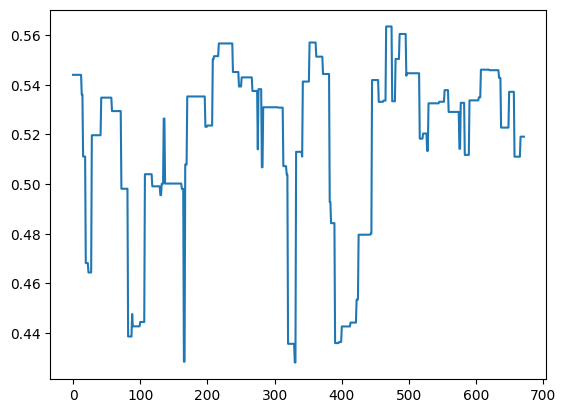

In [9]:
average_request_time_response = get_average(prov_async['response_time'], 30)
sns.lineplot(y=average_request_time_response, x=range(len(average_request_time_response)))

<AxesSubplot: >

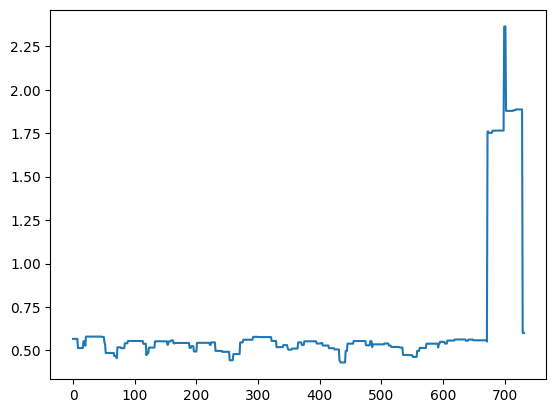

In [10]:
average_request_time_response = get_average(without_writing['response_time'], 30)
sns.lineplot(y=average_request_time_response, x=range(len(average_request_time_response)))

<AxesSubplot: >

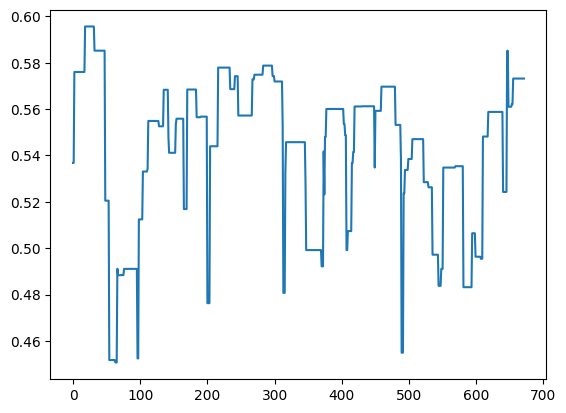

In [11]:
average_request_time_response = get_average(prov_sync['response_time'], 30)
sns.lineplot(y=average_request_time_response, x=range(len(average_request_time_response)))

In [59]:
import timeit
import time
import uuid
start = time.time()
print(str(uuid.uuid4()))
print(time.time() - start)

6e139063-eb31-495b-8434-aa7bbc61935d
6.127357482910156e-05


In [62]:
path = '/home/nguu0123/git/thesis/ray_deployment/logs/'
inference_log = pd.read_csv(path + 'inference_log.csv')
models_log    = pd.read_csv(path + 'models_log.csv')
request_log   = pd.read_csv(path + 'request_log.csv')
server_log    = pd.read_csv(path + 'server_log.csv')
classes       = ['bicycle', 'car', 'cat', 'dog', 'person']

<AxesSubplot: >

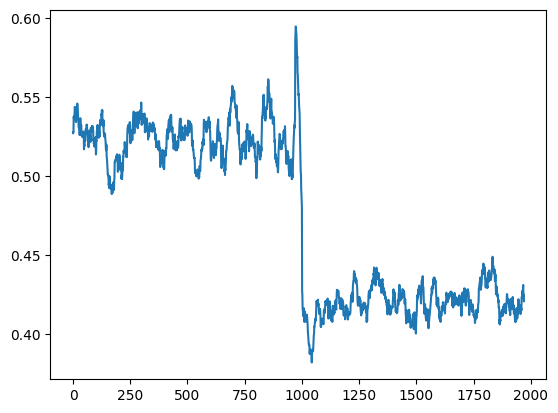

In [64]:
average_request_time_response = get_average(request_log['Response time'], 30)
sns.lineplot(y=average_request_time_response, x=range(len(average_request_time_response)))

<AxesSubplot: >

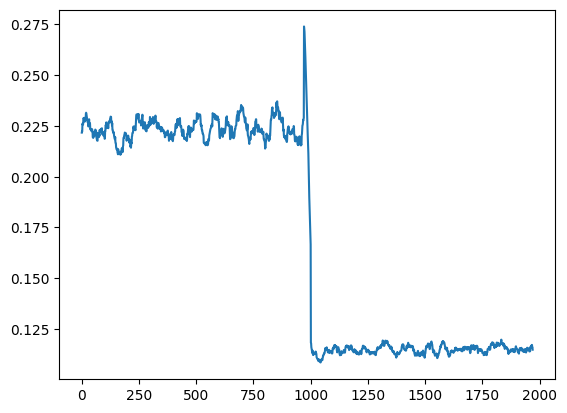

In [65]:
average_inference_time = get_average(server_log['Response time'], 30)
sns.lineplot(y=average_inference_time, x=range(len(average_inference_time)))

In [66]:
yolo5n = inference_log[(inference_log["Model"] == 'yolov5n') & (inference_log["Class"] == 'cat')]
yolo5n['Object width'] * yolo5n['Object height']

2894         0.000000
2900    268333.278706
2936         0.000000
2939         0.000000
2956         0.000000
            ...      
5391    268155.407270
5410         0.000000
5504         0.000000
5507     56185.787161
5513    103914.161193
Length: 113, dtype: float64

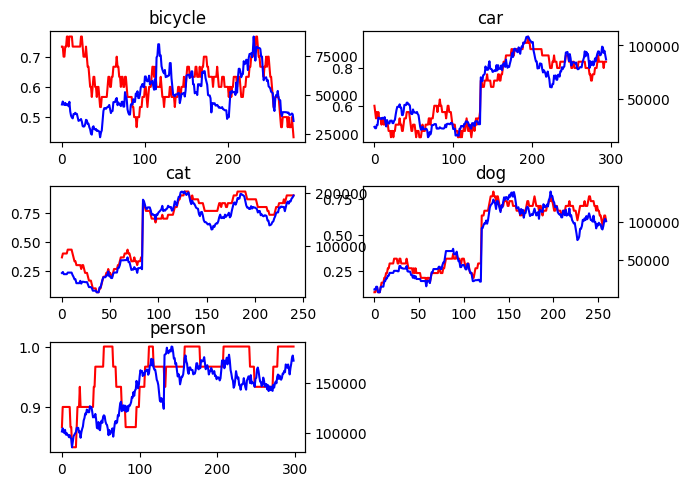

In [67]:
fig, axs = plt.subplots(3, 2)
fig.tight_layout()
fig.delaxes(axs[2][1])
i = 0 
j = 0
for cur_class in classes:
    yolo5n = inference_log[(inference_log["Model"] == 'yolov5n') & (inference_log["Class"] == cur_class)]
    yolo5s =  inference_log[(inference_log["Model"] == 'yolov5s') & (inference_log["Class"] == cur_class)]
    yolo5n_accuracy = get_average(yolo5n["Correctly detect"],30)
    yolo5s_accuracy = get_average(yolo5s["Correctly detect"],30)
    combined_accuracy = yolo5n_accuracy + yolo5s_accuracy
    average_object_size_yolo5n = get_average(yolo5n['Object width'] * yolo5n['Object height'], 30)
    average_object_size_yolo5s = get_average(yolo5s['Object width'] * yolo5s['Object height'], 30)
    average_object_size = average_object_size_yolo5n + average_object_size_yolo5s
    sns.lineplot(y=combined_accuracy, x=range(len(combined_accuracy)), ax=axs[i][j], color='red')
    ax2 = axs[i][j].twinx()
    sns.lineplot(y=average_object_size, x=range(len(average_object_size)), ax=ax2, color='blue')
    axs[i][j].set_title(cur_class)
    j = (j + 1) % 2
    if j == 0:
        i += 1


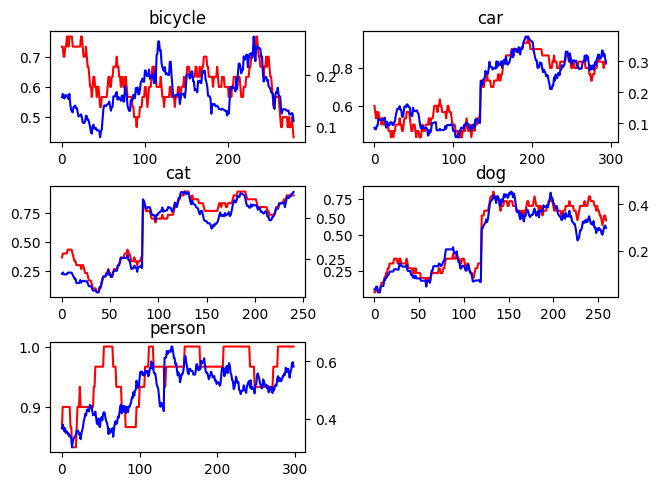

In [68]:
fig, axs = plt.subplots(3, 2)
fig.delaxes(axs[2][1])
fig.tight_layout()
i = 0 
j = 0
for cur_class in classes:
    yolo5n = inference_log[(inference_log["Model"] == 'yolov5n') & (inference_log["Class"] == cur_class)]
    yolo5s =  inference_log[(inference_log["Model"] == 'yolov5s') & (inference_log["Class"] == cur_class)]
    yolo5n_accuracy = get_average(yolo5n["Correctly detect"],30)
    yolo5s_accuracy = get_average(yolo5s["Correctly detect"],30)
    combined_accuracy = yolo5n_accuracy + yolo5s_accuracy
    average_object_percentage_yolo5n = get_average(yolo5n['Object to Image percentage'], 30)
    average_object_percentage_yolo5s = get_average(yolo5s['Object to Image percentage'], 30)
    average_object_percentage = average_object_percentage_yolo5n + average_object_percentage_yolo5s
    sns.lineplot(y=combined_accuracy, x=range(len(combined_accuracy)), ax=axs[i][j], color='red')
    ax2 = axs[i][j].twinx()
    sns.lineplot(y=average_object_percentage, x=range(len(average_object_percentage)), ax=ax2, color='blue')
    axs[i][j].set_title(cur_class)
    j = (j + 1) % 2
    if j == 0:
        i += 1



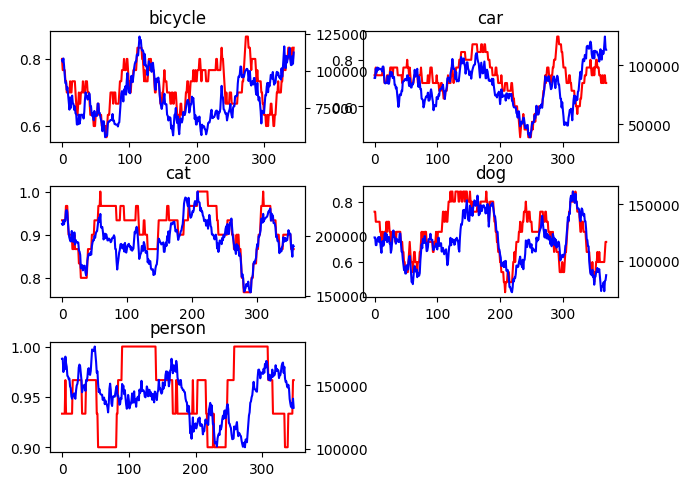

In [69]:
fig, axs = plt.subplots(3, 2)
fig.delaxes(axs[2][1])
fig.tight_layout()
i = 0 
j = 0
for cur_class in classes:
    yolo8n = inference_log[(inference_log["Model"] == 'yolov8n') & (inference_log["Class"] == cur_class)]
    yolo8n_accuracy = get_average(yolo8n["Correctly detect"],30)
    average_object_size = get_average(yolo8n['Object width'] * yolo8n['Object height'], 30)
    sns.lineplot(y=yolo8n_accuracy, x=range(len(yolo8n_accuracy)), ax=axs[i][j], color='red')
    ax2 = axs[i][j].twinx()
    sns.lineplot(y=average_object_size, x=range(len(average_object_size)), ax=ax2, color='blue')
    axs[i][j].set_title(cur_class)
    j = (j + 1) % 2
    if j == 0:
        i += 1

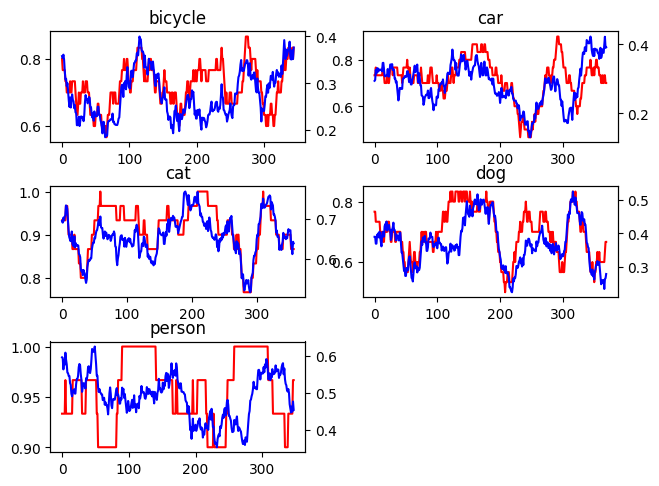

In [70]:
fig, axs = plt.subplots(3, 2)
fig.tight_layout()
i = 0 
j = 0
fig.delaxes(axs[2][1])
for cur_class in classes:
    yolo8n = inference_log[(inference_log["Model"] == 'yolov8n') & (inference_log["Class"] == cur_class)]
    yolo8n_accuracy = get_average(yolo8n["Correctly detect"],30)
    average_object_percentage_yolo8n = get_average(yolo8n['Object to Image percentage'], 30)
    sns.lineplot(y=yolo8n_accuracy, x=range(len(yolo8n_accuracy)), ax=axs[i][j], color='red')
    ax2 = axs[i][j].twinx()
    sns.lineplot(y=average_object_percentage_yolo8n, x=range(len(average_object_percentage_yolo8n)), ax=ax2, color='blue')
    axs[i][j].set_title(cur_class)
    j = (j + 1) % 2
    if j == 0:
        i += 1